# MSc in Data Science - Data Analytics & Algorithms
# Continuous Assessment: RNN Model Notebook

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Initialize log file
log_file = 'rnn_log.txt'
def log_entry(message):
    """Append a log entry to the text file with a timestamp."""
    with open(log_file, 'a') as f:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"[{timestamp}] {message}\n")

In [4]:
# Clear log file if it exists and start fresh
if os.path.exists(log_file):
    os.remove(log_file)
log_entry("=== RNN Model Log Started ===")
log_entry("Business Understanding: Predict IMDb ratings from movie overviews using RNN to analyze plot influence on ratings.")

In [5]:
# Load the dataset
log_entry("Loading dataset...")
imdb = pd.read_csv('./imdb_top_1000.csv')

In [6]:
# Display the first few rows of the dataset to verify
log_entry("Displaying first few rows of the dataset...")
print(imdb.head())

                                         Poster_Link  \
0  https://m.media-amazon.com/images/M/MV5BMDFkYT...   
1  https://m.media-amazon.com/images/M/MV5BM2MyNj...   
2  https://m.media-amazon.com/images/M/MV5BMTMxNT...   
3  https://m.media-amazon.com/images/M/MV5BMWMwMG...   
4  https://m.media-amazon.com/images/M/MV5BMWU4N2...   

               Series_Title Released_Year Certificate  Runtime  \
0  The Shawshank Redemption          1994           A  142 min   
1             The Godfather          1972           A  175 min   
2           The Dark Knight          2008          UA  152 min   
3    The Godfather: Part II          1974           A  202 min   
4              12 Angry Men          1957           U   96 min   

                  Genre  IMDB_Rating  \
0                 Drama          9.3   
1          Crime, Drama          9.2   
2  Action, Crime, Drama          9.0   
3          Crime, Drama          9.0   
4          Crime, Drama          9.0   

                         

## === Data Preparation ===

In [8]:
# Check for missing values in the dataset
log_entry("Checking for missing values in the dataset...")
print(imdb.isnull().sum())


Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In [9]:
# Remove missing values
log_entry("Removing missing values from the dataset...")
imdb = imdb.dropna()

In [10]:
# check missing values again
log_entry("Checking for missing values in the dataset after removal...")
print(imdb.isnull().sum())

Poster_Link      0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64


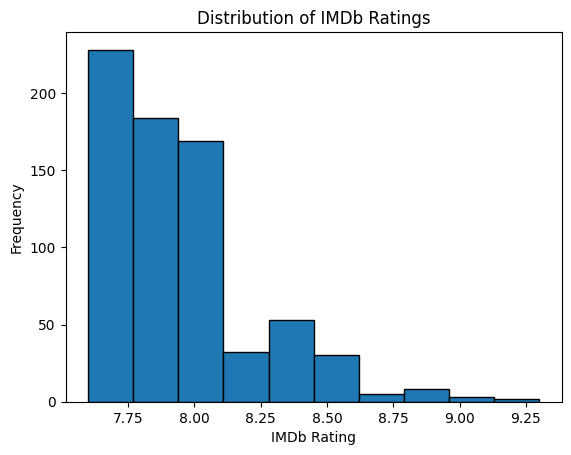

In [13]:
# Visualize the distribution of IMDb ratings
log_entry("Visualizing the distribution of IMDb ratings...")
plt.hist(imdb['IMDB_Rating'], bins=10, edgecolor='black')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.title('Distribution of IMDb Ratings')
plt.show()


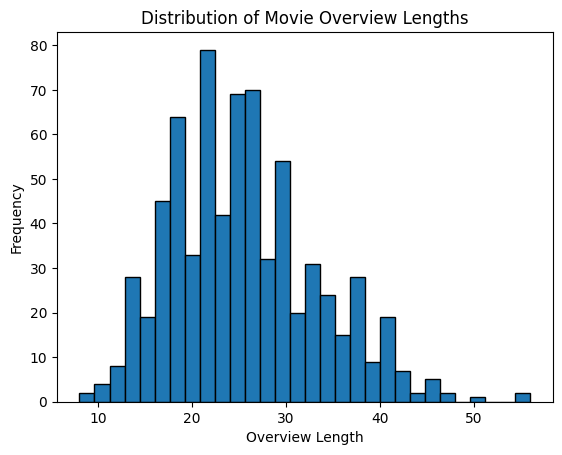

In [14]:
# Visualize the distribution of movie overviews lengths
log_entry("Visualizing the distribution of movie overview lengths...")
imdb['overview_length'] = imdb['Overview'].apply(lambda x: len(x.split()))
plt.hist(imdb['overview_length'], bins=30, edgecolor='black')
plt.xlabel('Overview Length')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Overview Lengths')
plt.show()


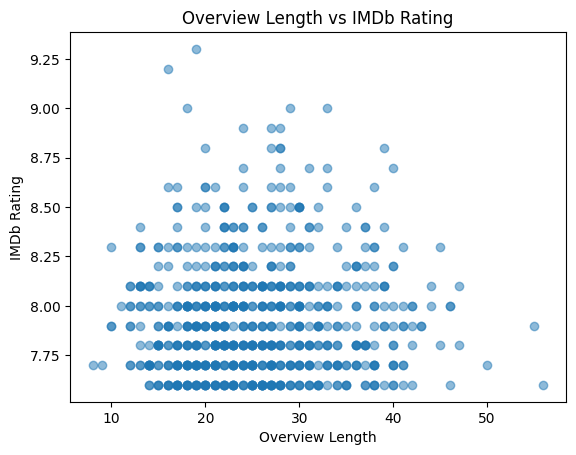

In [15]:
# Visualize the relationship between overview length and IMDb rating
log_entry("Visualizing the relationship between overview length and IMDb rating...")
plt.scatter(imdb['overview_length'], imdb['IMDB_Rating'], alpha=0.5)
plt.xlabel('Overview Length')
plt.ylabel('IMDb Rating')
plt.title('Overview Length vs IMDb Rating')
plt.show()


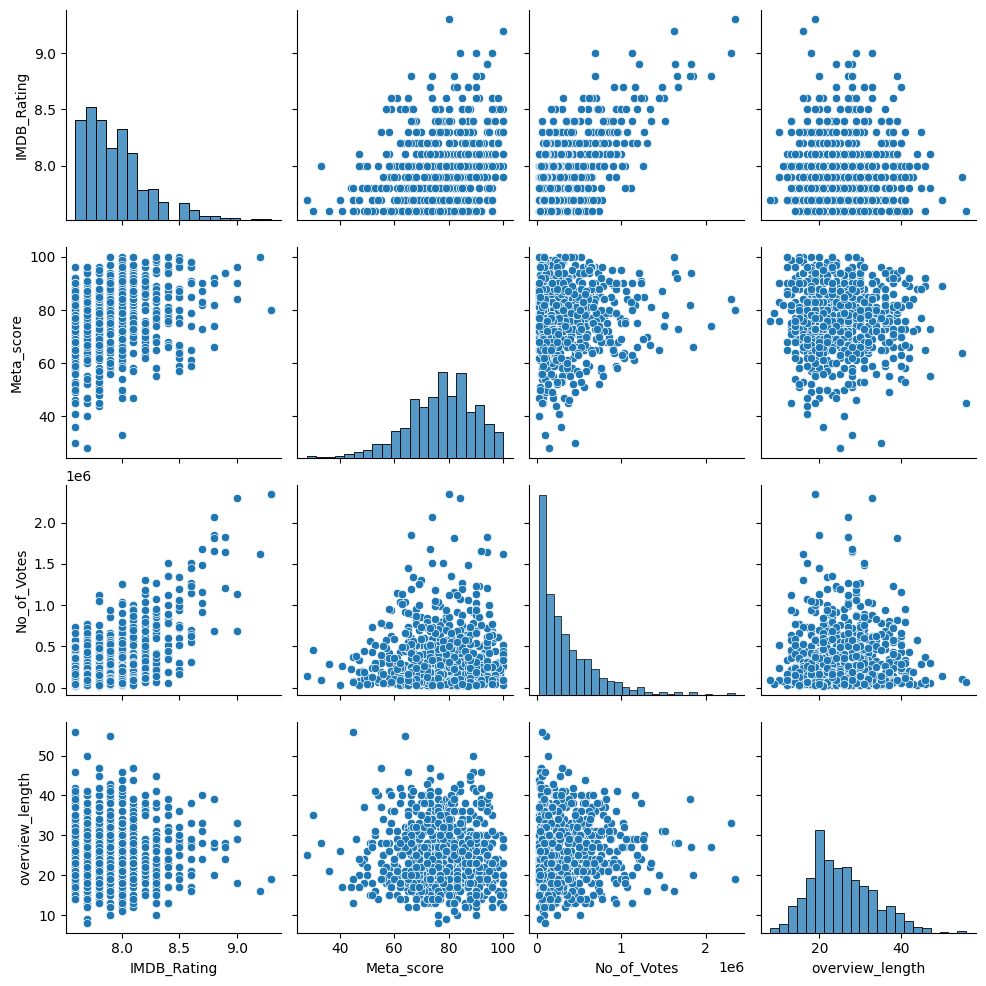

In [17]:
# visualize the pairplot of the dataset
log_entry("Visualizing the pairplot of the dataset...")
import seaborn as sns
sns.pairplot(imdb)
plt.show()


In [19]:
# Extract features and target
overviews = imdb['Overview'].values
ratings = imdb['IMDB_Rating'].values

In [21]:
# Text preprocessing
max_words = 5000  # Maximum number of words to consider in vocabulary
max_len = 100     # Maximum length of each sequence
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(overviews)
sequences = tokenizer.texts_to_sequences(overviews)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

log_entry("Text preprocessing completed...")

In [22]:
# Significant Adjustment 1: Normalize ratings to [0, 1] range
ratings_normalized = (ratings - ratings.min()) / (ratings.max() - ratings.min())
log_entry(f"Data Preparation: Tokenized overviews (max_words={max_words}, max_len={max_len}), normalized ratings to [0, 1].")
print(f"Sample padded sequence shape: {padded_sequences.shape}")
print(f"Sample normalized rating: {ratings_normalized[0]}")

Sample padded sequence shape: (714, 100)
Sample normalized rating: 1.0


In [23]:
# Split into training and testing sets (80-20 split)
split = int(0.8 * len(padded_sequences))
X_train, X_test = padded_sequences[:split], padded_sequences[split:]
y_train, y_test = ratings_normalized[:split], ratings_normalized[split:]

log_entry(f"Data Preparation: Split data into {split} training and {len(padded_sequences) - split} testing samples.")

In [24]:
# === Modeling: Baseline RNN ===
def build_baseline_rnn():
    """Build a simple RNN model."""
    model = models.Sequential([
        layers.Embedding(max_words, 32, input_length=max_len),
        layers.SimpleRNN(64),
        layers.Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [25]:
# Train baseline model
log_entry("Modeling: Training baseline RNN with SimpleRNN (64 units).")
baseline_model = build_baseline_rnn()
baseline_history = baseline_model.fit(X_train, y_train, epochs=5, batch_size=32, 
                                     validation_data=(X_test, y_test), verbose=1)

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0299 - mae: 0.1337 - val_loss: 0.0478 - val_mae: 0.2171
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0231 - mae: 0.1157 - val_loss: 0.0626 - val_mae: 0.2468
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0171 - mae: 0.1032 - val_loss: 0.0454 - val_mae: 0.1815
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0153 - mae: 0.0944 - val_loss: 0.0932 - val_mae: 0.2845
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0143 - mae: 0.0936 - val_loss: 0.0988 - val_mae: 0.3014


In [26]:
# Evaluate baseline model
baseline_test_loss, baseline_test_mae = baseline_model.evaluate(X_test, y_test, verbose=0)
log_entry(f"Evaluation: Baseline RNN - Test MSE: {baseline_test_loss:.4f}, Test MAE: {baseline_test_mae:.4f}")
print(f"Baseline RNN - Test MSE: {baseline_test_loss:.4f}, Test MAE: {baseline_test_mae:.4f}")

Baseline RNN - Test MSE: 0.0988, Test MAE: 0.3014


In [28]:
# Evaluate Rmse, R^2 and adjusted R^2
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_pred = baseline_model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
log_entry(f"Evaluation: Baseline RNN - Test RMSE: {rmse:.4f}")

# R^2
r2 = r2_score(y_test, y_pred)
log_entry(f"Evaluation: Baseline RNN - Test R^2: {r2:.4f}")
print(f"Baseline RNN - Test RMSE: {rmse:.4f}, Test R^2: {r2:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Baseline RNN - Test RMSE: 0.3144, Test R^2: -150.6509


## === Modeling: Hyperparameter Tuned RNN ===

In [29]:
# === Modeling: Tuned RNN ===
def build_tuned_rnn():
    """Build a tuned RNN with LSTM and dropout."""
    model = models.Sequential([
        layers.Embedding(max_words, 64, input_length=max_len),  # Increased embedding size
        layers.LSTM(128, return_sequences=True),  # LSTM with return sequences
        layers.Dropout(0.3),
        layers.LSTM(64),  # Second LSTM layer
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='mse', metrics=['mae'])
    return model

In [30]:
# Train tuned model
log_entry("Modeling: Training tuned RNN with LSTM (128, 64 units), dropout 0.3, learning rate 0.0001.")
tuned_model = build_tuned_rnn()
tuned_history = tuned_model.fit(X_train, y_train, epochs=5, batch_size=32, 
                                validation_data=(X_test, y_test), verbose=1)

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - loss: 0.0647 - mae: 0.2043 - val_loss: 0.0223 - val_mae: 0.1470
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 0.0255 - mae: 0.1171 - val_loss: 0.0867 - val_mae: 0.2933
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - loss: 0.0287 - mae: 0.1342 - val_loss: 0.0494 - val_mae: 0.2207
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - loss: 0.0249 - mae: 0.1192 - val_loss: 0.0640 - val_mae: 0.2517
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - loss: 0.0254 - mae: 0.1243 - val_loss: 0.0570 - val_mae: 0.2374


In [31]:
# Evaluate tuned model
tuned_test_loss, tuned_test_mae = tuned_model.evaluate(X_test, y_test, verbose=0)
log_entry(f"Evaluation: Tuned RNN - Test MSE: {tuned_test_loss:.4f}, Test MAE: {tuned_test_mae:.4f}, Test RMSE: {np.sqrt(tuned_test_loss):.4f}, Test R^2: {r2_score(y_test, tuned_model.predict(X_test)):.4f}")
print(f"Tuned RNN - Test MSE: {tuned_test_loss:.4f}, Test MAE: {tuned_test_mae:.4f}, Test RMSE: {np.sqrt(tuned_test_loss):.4f}, Test R^2: {r2_score(y_test, tuned_model.predict(X_test)):.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Tuned RNN - Test MSE: 0.0570, Test MAE: 0.2374, Test RMSE: 0.2387, Test R^2: -86.4424


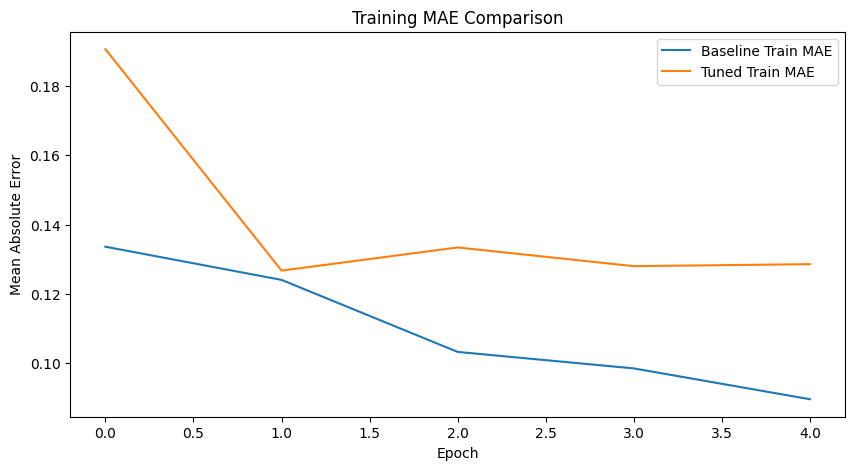

In [32]:
# === Visualization ===
plt.figure(figsize=(10, 5))
plt.plot(baseline_history.history['mae'], label='Baseline Train MAE')
plt.plot(tuned_history.history['mae'], label='Tuned Train MAE')
plt.title('Training MAE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('rnn_mae_plot.png')  # Save plot for portfolio
plt.show()

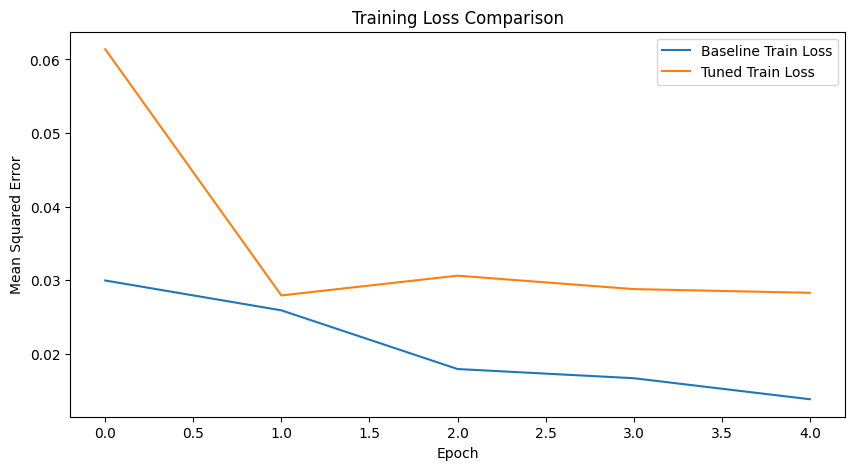

In [33]:
# Visualize the training loss of mse 
plt.figure(figsize=(10, 5))
plt.plot(baseline_history.history['loss'], label='Baseline Train Loss')
plt.plot(tuned_history.history['loss'], label='Tuned Train Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('rnn_mse_plot.png')  # Save plot for portfolio
plt.show()

log_entry("Visualizing training MAE and loss for baseline and tuned RNN models.")

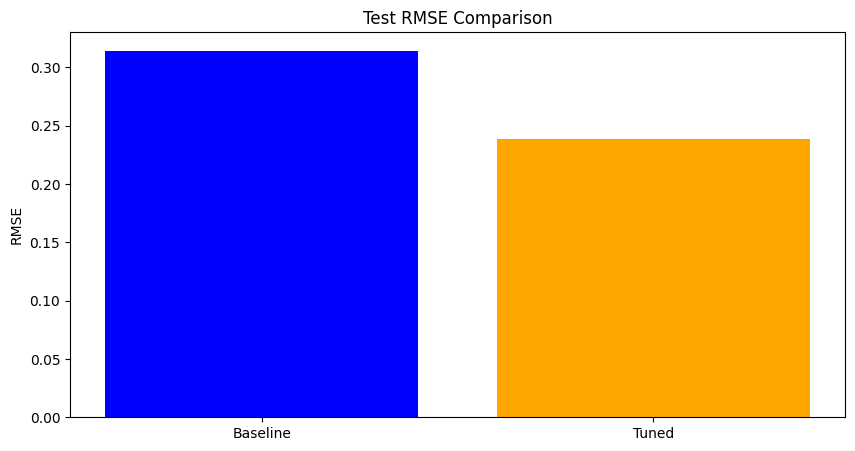

In [34]:
# visualize the rmse and r^2 of the models
plt.figure(figsize=(10, 5))
plt.bar(['Baseline', 'Tuned'], [rmse, np.sqrt(tuned_test_loss)], color=['blue', 'orange'])
plt.title('Test RMSE Comparison')
plt.ylabel('RMSE')
plt.savefig('rnn_rmse_plot.png')  # Save plot for portfolio
plt.show()


In [35]:
# === Analysis ===
log_entry(f"Analysis: Tuned RNN reduced MAE by ~{baseline_test_mae - tuned_test_mae:.4f} compared to baseline.")
log_entry("Analysis: LSTM layers and dropout improved model generalization on text data.")
log_entry("Analysis: Limited epochs (5) used to avoid overfitting; more data could enhance performance.")

In [37]:
# === Minimal Deployment ===
# Save the tuned model
model_filename = 'rnn_tuned_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(tuned_model, file)
log_entry(f"Deployment: Tuned model saved as {model_filename}")
print(f"Tuned model saved as {model_filename}")

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
log_entry("Deployment: Tokenizer saved as 'tokenizer.pkl'")

# Test prediction function
def predict_rating(model, tokenizer, overview, max_len=100):
    """Predict IMDb rating from an overview."""
    sequence = tokenizer.texts_to_sequences([overview])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(padded, verbose=0)[0][0]
    # Denormalize prediction back to original scale
    min_rating, max_rating = ratings.min(), ratings.max()
    return pred * (max_rating - min_rating) + min_rating

sample_overview = imdb['Overview'][0]
sample_rating = imdb['IMDB_Rating'][0]
predicted_rating = predict_rating(tuned_model, tokenizer, sample_overview)
log_entry(f"Deployment: Sample Prediction - Overview: '{sample_overview}', Predicted: {predicted_rating:.2f}, True: {sample_rating}")
print(f"Sample Prediction - Predicted: {predicted_rating:.2f}, True: {sample_rating}")

# Final log entry
log_entry("=== RNN Model Log Completed ===")
log_entry("Submission Notes: Files included - this notebook, rnn_tuned_model.pkl, tokenizer.pkl, rnn_log.txt, rnn_mae_plot.png")
log_entry("Sources: TensorFlow (https://www.tensorflow.org/), Pandas (https://pandas.pydata.org/), IMDb dataset provided.")

# === End of Notebook ===

Tuned model saved as rnn_tuned_model.pkl
Sample Prediction - Predicted: 8.03, True: 9.3
